# Machine Learning Volatility Modeling
## Master's Thesis - Empirical Study 
### Università della Svizzera italiana

Pietro Bonazzi - pietro.bonazzi@usi.ch

Preliminary analysis - v 0.2

In [34]:
# Testing platform module and environment
import platform
platform.machine()

'arm64'

In [3]:
# Importing modules
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.collections import PolyCollection

In [4]:
# Import price data
df_temp = pd.read_csv('raw_data/trade_price.csv')
df_temp.index = pd.to_datetime(df_temp['event_timestamp'])
df_temp = df_temp.drop([df_temp.columns[0],'Date', 'ListingId', 'event_timestamp', 'CurrencyCode', 'ISIN'], axis=1)

In [5]:
df_price = df_temp.pivot_table(index=df_temp.index, columns='Ticker', values='mid')
df_price.drop(['ALC','SGSN','STMN'], axis=1, inplace=True)
df_price.dropna(inplace=True)
df_price.isna().sum()
df_price.head()

Ticker,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
event_timestamp,,,,,,,,,,,,,,,,,
2014-12-15 09:00:00,20.080,86.325,333.70,1755.0,67.95,130.05,110.35,70.425,90.775,270.25,286.25,568.0,2970.0,139.55,82.225,17.015,299.40
2014-12-15 09:10:00,20.110,86.700,333.75,1758.0,67.85,130.25,111.90,70.575,91.025,270.25,286.70,569.5,2912.0,139.40,82.100,16.965,299.65
2014-12-15 09:20:00,20.070,87.125,332.90,1757.0,67.50,130.25,111.45,70.575,91.275,270.50,286.35,568.5,2923.5,139.40,82.025,16.940,299.70
2014-12-15 09:30:00,20.170,87.150,334.35,1758.5,67.95,130.15,111.40,70.475,91.275,270.50,286.20,570.0,2927.0,139.90,82.200,16.970,299.95
2014-12-15 09:40:00,20.165,87.250,334.05,1760.0,67.90,130.10,111.40,70.400,91.075,270.50,285.25,569.5,2943.5,139.75,82.200,16.975,299.35


In [6]:
# Asjusting for SIKA stock split 
date_split = pd.to_datetime('2018-06-13')
df_price.loc[df_price.index < date_split, 'SIKA'] /= 60     #60:1 stock split
df_price = df_price.round(3)

In [7]:
# Create returns dataframe
df_returns = np.log(df_price) - np.log(df_price.shift(1))
df_returns.dropna(inplace=True)
df_returns.head()

Ticker,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
event_timestamp,,,,,,,,,,,,,,,,,
2014-12-15 09:10:00,0.001493,0.004335,0.000150,0.001708,-0.001473,0.001537,0.013948,0.002128,0.002750,0.000000,0.001571,0.002637,-0.019729,-0.001075,-0.001521,-0.002943,0.000835
2014-12-15 09:20:00,-0.001991,0.004890,-0.002550,-0.000569,-0.005172,0.000000,-0.004030,0.000000,0.002743,0.000925,-0.001222,-0.001757,0.003948,0.000000,-0.000914,-0.001475,0.000167
2014-12-15 09:30:00,0.004970,0.000287,0.004346,0.000853,0.006645,-0.000768,-0.000449,-0.001418,0.000000,0.000000,-0.000524,0.002635,0.001190,0.003580,0.002131,0.001769,0.000834
2014-12-15 09:40:00,-0.000248,0.001147,-0.000898,0.000853,-0.000736,-0.000384,0.000000,-0.001065,-0.002194,0.000000,-0.003325,-0.000878,0.005621,-0.001073,0.000000,0.000295,-0.002002
2014-12-15 09:50:00,0.002476,0.000859,-0.000150,0.000000,0.000736,0.000768,0.000897,-0.001777,-0.001373,0.000462,-0.004040,-0.001757,0.003053,-0.000358,0.002127,0.000000,0.001002


<Axes: xlabel='event_timestamp'>

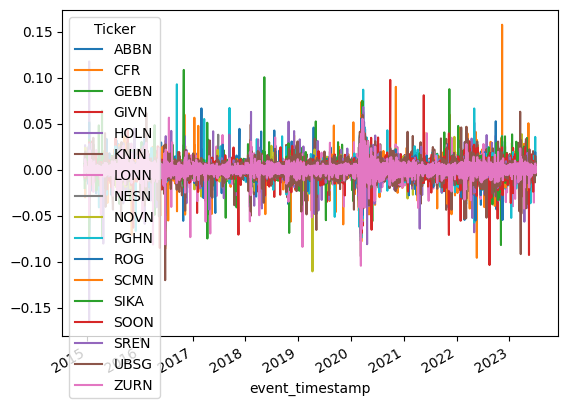

In [8]:
# Plotting returns
df_returns.plot()

In [9]:
# Summary statistics returns
df_summary = pd.DataFrame({'count': df_returns.count(),
                           'mean': df_returns.mean().round(2),
                           'var': df_returns.var().round(2),
                           'sd': df_returns.std().round(2),
                           'min': df_returns.min().round(2),
                           'max': df_returns.max().round(2),
                           'skew': df_returns.skew().round(2),
                           'kurt': df_returns.kurt().round(2),
                           'JB stat': df_returns.apply(lambda x: stats.jarque_bera(x)[0]).apply(lambda x: '{:.1e}'.format(x)),
                           'JB p-val': df_returns.apply(lambda x: stats.jarque_bera(x)[1]).round(2),
                           'LB stat (10)': df_returns.head(20000).apply(lambda x: acorr_ljungbox(x, lags=[10])['lb_stat'][10]).round(2),
                           'LB p-val (10)': df_returns.head(20000).apply(lambda x: acorr_ljungbox(x, lags=[10])['lb_pvalue'][10]).round(2),
                           'ADF stat': df_returns.head(10000).apply(lambda x: adfuller(x)[0]).round(2),
                           'ADF p-val': df_returns.head(10000).apply(lambda x: adfuller(x)[1]).round(2)
                           })

df_summary

,count,mean,var,sd,min,max,skew,kurt,JB stat,JB p-val,LB stat (10),LB p-val (10),ADF stat,ADF p-val
Ticker,,,,,,,,,,,,,,
ABBN,107049,0.0,0.0,0.0,-0.08,0.06,-1.76,93.11,3.9e+07,0.0,36.01,0.00,-14.81,0.0
CFR,107049,0.0,0.0,0.0,-0.10,0.16,0.75,207.24,1.9e+08,0.0,44.02,0.00,-14.09,0.0
GEBN,107049,0.0,0.0,0.0,-0.08,0.05,-1.78,101.20,4.6e+07,0.0,66.10,0.00,-24.56,0.0
GIVN,107049,0.0,0.0,0.0,-0.06,0.04,-1.53,65.38,1.9e+07,0.0,94.49,0.00,-15.53,0.0
HOLN,107049,-0.0,0.0,0.0,-0.16,0.12,-2.18,270.46,3.3e+08,0.0,107.54,0.00,-26.58,0.0
KNIN,107049,0.0,0.0,0.0,-0.05,0.05,-0.82,56.62,1.4e+07,0.0,56.53,0.00,-25.21,0.0
LONN,107049,0.0,0.0,0.0,-0.08,0.06,-1.43,71.14,2.3e+07,0.0,61.82,0.00,-13.77,0.0
NESN,107049,0.0,0.0,0.0,-0.05,0.05,-1.05,79.41,2.8e+07,0.0,122.58,0.00,-14.78,0.0
NOVN,107049,-0.0,0.0,0.0,-0.11,0.06,-3.34,224.42,2.2e+08,0.0,68.23,0.00,-20.41,0.0


In [10]:
# Exporting summary statistics to latex
df_summary.to_latex('tables/df_summary_returns.tex', float_format="%.2f")

In [11]:
# Realized volatility dataframe
df_rv = df_returns.groupby(df_returns.index.date).apply(lambda x: np.sqrt((x ** 2).sum()))
df_rv.head()

Ticker,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
2014-12-15,0.010667,0.012136,0.010994,0.006673,0.013296,0.007213,0.022369,0.008987,0.012430,0.010858,0.012451,0.012174,0.027229,0.012442,0.009429,0.009981,0.008318
2014-12-16,0.014924,0.019417,0.016124,0.013686,0.026749,0.011004,0.021438,0.013273,0.018647,0.018431,0.019520,0.018186,0.019887,0.015328,0.013924,0.016156,0.016018
2014-12-17,0.011636,0.012505,0.009275,0.009112,0.016373,0.013430,0.015193,0.006119,0.010961,0.011930,0.010605,0.010610,0.026055,0.013394,0.009942,0.010568,0.008437
2014-12-18,0.017820,0.019603,0.016729,0.014596,0.029193,0.012504,0.026171,0.010577,0.023674,0.017864,0.017106,0.056025,0.020750,0.012199,0.011329,0.014132,0.012370
2014-12-19,0.019083,0.020474,0.015581,0.012572,0.018382,0.012956,0.021343,0.015958,0.026937,0.013676,0.036735,0.016522,0.022875,0.016411,0.013791,0.023170,0.014133


In [15]:
df_summary = pd.DataFrame({'count': df_rv.count(),
                           'mean': df_rv.mean().round(2),
                           'var': df_rv.var().round(2),
                           'sd': df_rv.std().round(2),
                           'min': df_rv.min().round(2),
                           'max': df_rv.max().round(2),
                           'skew': df_rv.skew().round(2),
                           'kurt': df_rv.kurt().round(2),
                           'JB stat': df_rv.apply(lambda x: stats.jarque_bera(x)[0]).apply(lambda x: '{:.1e}'.format(x)),
                           'JB p-val': df_rv.apply(lambda x: stats.jarque_bera(x)[1]).round(2),
                           'LB stat (10)': df_rv.apply(lambda x: acorr_ljungbox(x, lags=[10])['lb_stat'][10]).round(2),
                           'LB p-val (10)': df_rv.apply(lambda x: acorr_ljungbox(x, lags=[10])['lb_pvalue'][10]).round(2),
                           'ADF stat': df_rv.apply(lambda x: adfuller(x)[0]).round(2),
                           'ADF p-val': df_rv.apply(lambda x: adfuller(x)[1]).round(2)
                           })
df_summary.round(2)

,count,mean,var,sd,min,max,skew,kurt,JB stat,JB p-val,LB stat (10),LB p-val (10),ADF stat,ADF p-val
Ticker,,,,,,,,,,,,,,
ABBN,2143,0.01,0.0,0.01,0.0,0.09,3.69,21.64,4.6e+04,0.0,3790.86,0.0,-6.30,0.0
CFR,2143,0.02,0.0,0.01,0.0,0.17,4.38,35.20,1.2e+05,0.0,2438.46,0.0,-6.51,0.0
GEBN,2143,0.01,0.0,0.01,0.0,0.10,3.99,26.92,7.0e+04,0.0,3844.55,0.0,-7.21,0.0
GIVN,2143,0.01,0.0,0.01,0.0,0.09,3.56,22.52,5.0e+04,0.0,4798.13,0.0,-6.98,0.0
HOLN,2143,0.02,0.0,0.01,0.0,0.23,6.85,106.20,1.0e+06,0.0,2939.16,0.0,-7.43,0.0
KNIN,2143,0.01,0.0,0.01,0.0,0.08,2.75,11.22,1.4e+04,0.0,3607.35,0.0,-4.48,0.0
LONN,2143,0.02,0.0,0.01,0.0,0.11,3.65,22.14,4.8e+04,0.0,2343.60,0.0,-10.19,0.0
NESN,2143,0.01,0.0,0.01,0.0,0.08,5.33,46.01,2.0e+05,0.0,4319.97,0.0,-7.87,0.0
NOVN,2143,0.01,0.0,0.01,0.0,0.11,5.84,55.59,2.9e+05,0.0,3007.46,0.0,-8.29,0.0


In [16]:
df_summary.to_latex('tables/df_summary_RV.tex', float_format="%.2f")

In [17]:
# Realized squared root quarticity dataframe
df_rq = df_returns.groupby(df_returns.index.date).apply(lambda x: np.sqrt((x ** 4).sum()))
df_rq.head()

Ticker,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
2014-12-15,0.000037,0.000052,0.000032,0.000017,0.000062,0.000016,0.000233,0.000020,0.000046,0.000031,0.000052,0.000045,0.000397,0.000046,0.000025,0.000029,0.000021
2014-12-16,0.000049,0.000092,0.000074,0.000057,0.000310,0.000030,0.000124,0.000041,0.000078,0.000076,0.000103,0.000090,0.000106,0.000062,0.000055,0.000057,0.000074
2014-12-17,0.000034,0.000051,0.000021,0.000026,0.000078,0.000093,0.000077,0.000011,0.000027,0.000042,0.000030,0.000026,0.000221,0.000084,0.000026,0.000037,0.000017
2014-12-18,0.000224,0.000144,0.000158,0.000131,0.000722,0.000094,0.000375,0.000053,0.000459,0.000137,0.000195,0.001391,0.000173,0.000050,0.000075,0.000135,0.000092
2014-12-19,0.000246,0.000204,0.000119,0.000037,0.000214,0.000105,0.000181,0.000195,0.000573,0.000044,0.000815,0.000075,0.000157,0.000124,0.000144,0.000401,0.000137


## Graphs for stylized facts

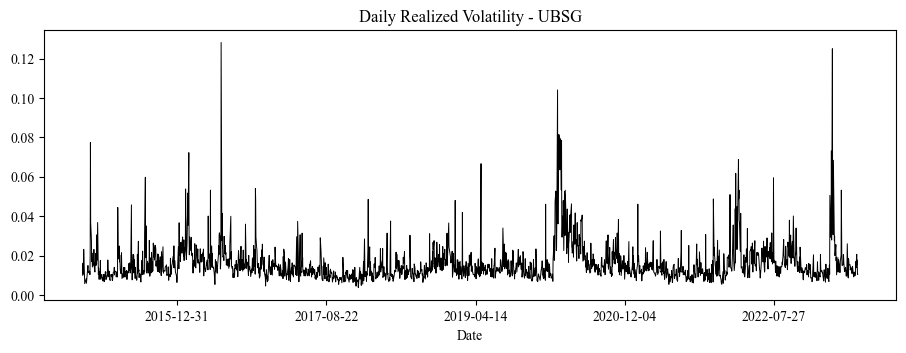

In [18]:
# Plot RV
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(11, 3.5))
ax.plot(df_rv['UBSG'], color='black', linewidth=0.7)

# set x-axis label and tick frequency
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_title('Daily Realized Volatility - UBSG')

plt.show()

fig.savefig("plots/RV_plot_UBSG.pdf")

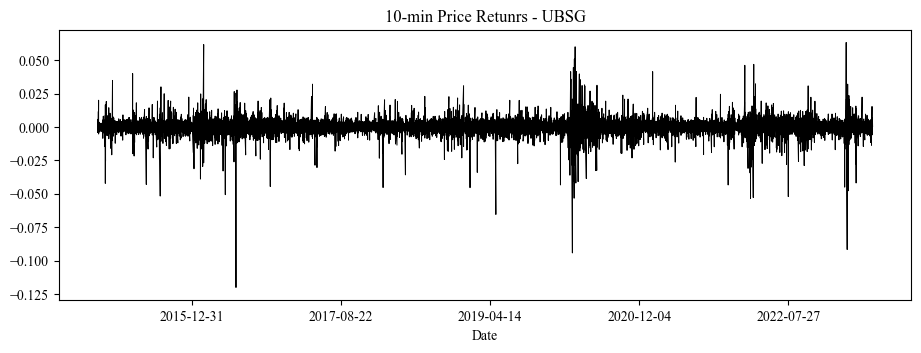

In [19]:
fig, ax = plt.subplots(figsize=(11, 3.5))
ax.plot(df_returns['UBSG'], color='black', linewidth=0.7)

# set x-axis label and tick frequency
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_title('10-min Price Retunrs - UBSG')

plt.show()

fig.savefig("plots/returns_plot_UBSG.pdf", bbox_inches='tight')

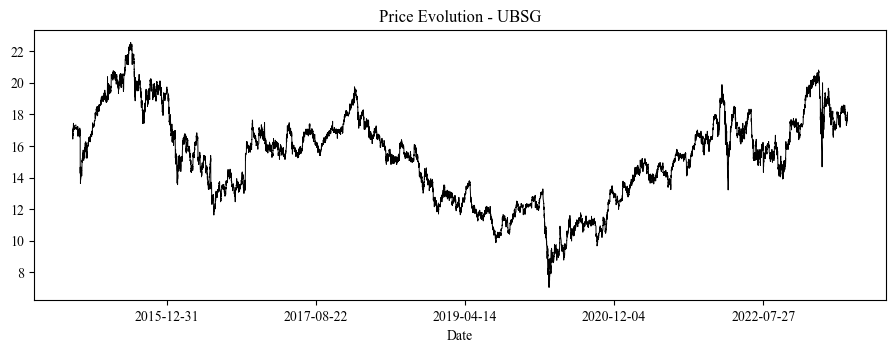

In [21]:
fig, ax = plt.subplots(figsize=(11, 3.5))
ax.plot(df_price['UBSG'], color='black', linewidth=0.7)

# set x-axis label and tick frequency
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

# set plot title
ax.set_title('Price Evolution - UBSG')

# show the plot
plt.show()

fig.savefig("plots/price_plot_UBSG.pdf", bbox_inches='tight')

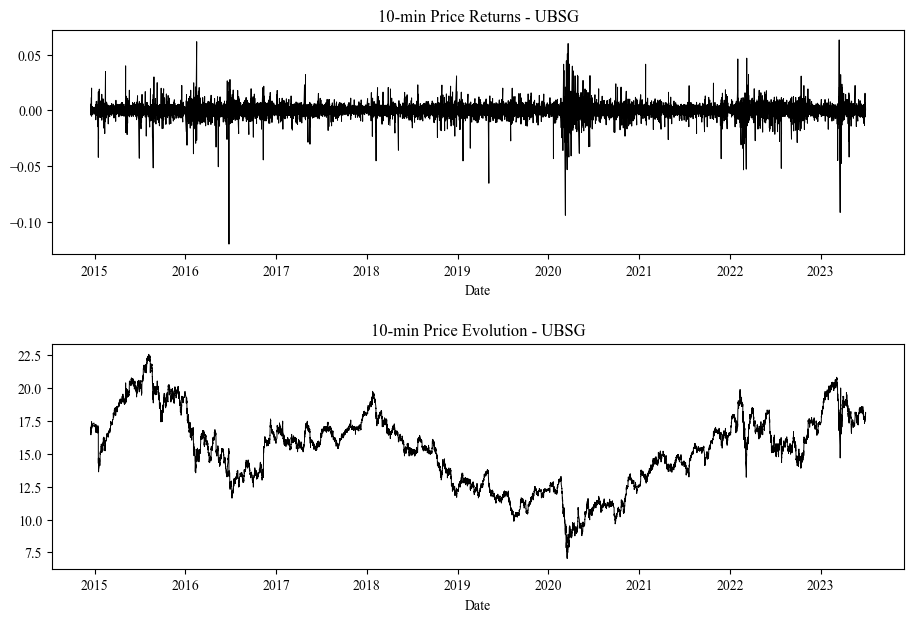

In [22]:
# Combine plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7))

ax1.plot(df_returns['UBSG'], color='black', linewidth=0.7)
ax1.set_xlabel('Date')
ax1.set_title('10-min Price Returns - UBSG')

ax2.plot(df_price['UBSG'], color='black', linewidth=0.7)
ax2.set_xlabel('Date')
ax2.set_title('10-min Price Evolution - UBSG')

plt.subplots_adjust(hspace=0.4)

fig.savefig("plots/merged_plot_UBSG.pdf", bbox_inches='tight')

plt.show()


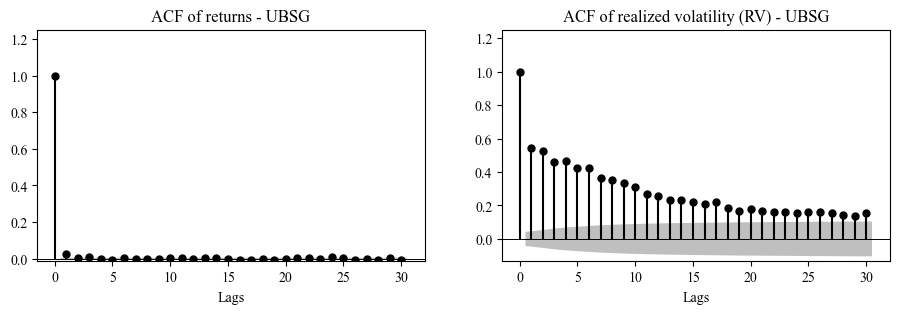

In [23]:
# ACF plots - returns and RV

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

plot_acf(df_returns['UBSG'], lags=30, ax=ax1, color='black', linewidth=0.7, vlines_kwargs={"colors": 'black'}, auto_ylims=True, 
         title='ACF of returns - UBSG')
for item in ax1.collections:
    if type(item)==PolyCollection:   # change color of confidence interval
        item.set_facecolor('black')
ax1.set_xlabel('Lags')


plot_acf(df_rv['UBSG'], ax=ax2, lags=30, color='black', linewidth=0.7, vlines_kwargs={"colors": 'black'}, auto_ylims=True,
         title='ACF of realized volatility (RV) - UBSG')
for item in ax2.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('black')
ax2.set_xlabel('Lags')

plt.subplots_adjust(wspace=0.2)
plt.show()

fig.savefig("plots/ACF_UBSG.pdf", bbox_inches='tight')


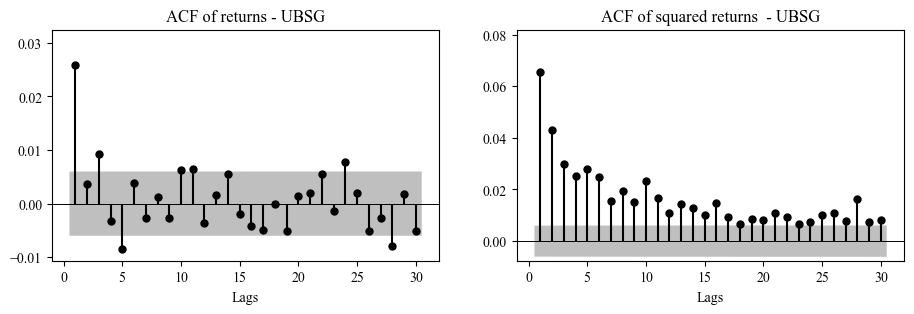

In [24]:
# ACF plots - returns and squared returns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

plot_acf(df_returns['UBSG'], lags=30, ax=ax1, color='black', linewidth=0.7, vlines_kwargs={"colors": 'black'}, auto_ylims=True, 
         title='ACF of returns - UBSG', zero = False )
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('black')
ax1.set_xlabel('Lags')


plot_acf(df_returns['UBSG']**2, ax=ax2, lags=30, color='black', linewidth=0.7, vlines_kwargs={"colors": 'black'}, auto_ylims=True,
         title='ACF of squared returns  - UBSG', zero = False )
for item in ax2.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('black')
ax2.set_xlabel('Lags')

plt.subplots_adjust(wspace=0.2)
plt.show()

fig.savefig("plots/ACF_ret_retsqared_UBSG.pdf", bbox_inches='tight')

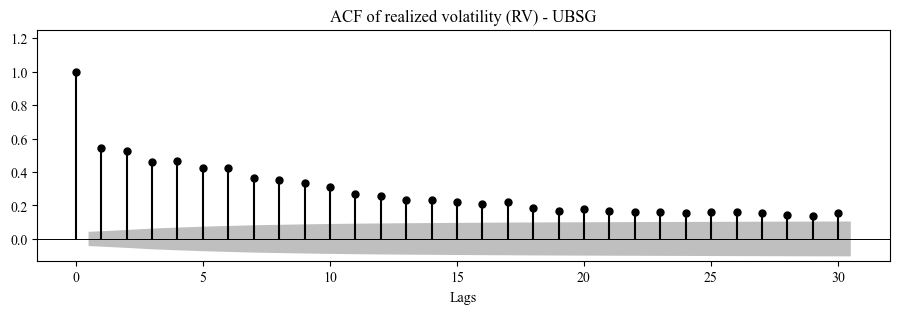

In [25]:
# ACF plots - RV
fig, (ax1) = plt.subplots(1, 1, figsize=(11, 3))

plot_acf(df_rv['UBSG'], ax=ax1, lags=30, color='black', linewidth=0.7, vlines_kwargs={"colors": 'black'}, auto_ylims=True,
         title='ACF of realized volatility (RV) - UBSG')
for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('black')

ax1.set_xlabel('Lags')

plt.show()

fig.savefig("plots/ACF_RV_UBSG.pdf", bbox_inches='tight')


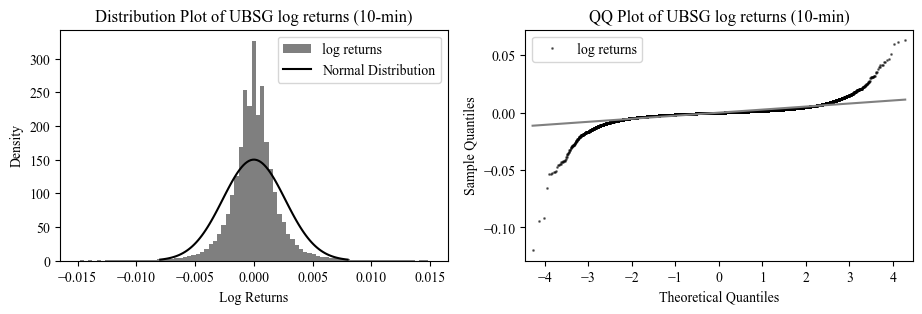

In [26]:
# QQ plot of returns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Distribution plot
ax1.hist(df_returns['UBSG'], bins=500, density=True, alpha=0.5, label='log returns', color='black')
ax1.set_xlabel('Log Returns')
ax1.set_ylabel('Density')
ax1.set_title('Distribution Plot of UBSG log returns (10-min)')

mu, sigma = df_returns['UBSG'].mean(), df_returns['UBSG'].std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), label='Normal Distribution', color='black')
ax1.legend()

# Limit the x-axis range
ax1.set_xlim(-0.0165, 0.0165)

# Generate the QQ plot
sm.qqplot(df_returns['UBSG'], line='s', fmt='k', ax=ax2, linewidth=0.7, marker='.', markersize=2, alpha=0.5, label='log returns', markerfacecolor='k', markeredgecolor='k')
ax2.set_title('QQ Plot of UBSG log returns (10-min)')
ax2.get_lines()[1].set_color("grey")
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.legend()

plt.show()

fig.savefig("plots/distrib+qqplot_UBSG.pdf", bbox_inches='tight')

### Create SQL Database

In [31]:
# Create DataBase in sqlite3
conn = sql.connect('data.db')
df_price.to_sql('price', conn)
df_returns.to_sql('returns', conn)
df_rv.to_sql('rv', conn)
df_rq.to_sql('rq', conn)
conn.close()


In [29]:
# Test read from DataBase
conn = sql.connect('data.db')
df_price = pd.read_sql('SELECT * FROM price', conn)
df_price


,event_timestamp,ABBN,CFR,GEBN,GIVN,HOLN,KNIN,LONN,NESN,NOVN,PGHN,ROG,SCMN,SIKA,SOON,SREN,UBSG,ZURN
0,2014-12-15 09:00:00,20.080,86.325,333.70,1755.0,67.95,130.05,110.35,70.425,90.775,270.25,286.250,568.0,49.500,139.55,82.225,17.015,299.40
1,2014-12-15 09:10:00,20.110,86.700,333.75,1758.0,67.85,130.25,111.90,70.575,91.025,270.25,286.700,569.5,48.533,139.40,82.100,16.965,299.65
2,2014-12-15 09:20:00,20.070,87.125,332.90,1757.0,67.50,130.25,111.45,70.575,91.275,270.50,286.350,568.5,48.725,139.40,82.025,16.940,299.70
3,2014-12-15 09:30:00,20.170,87.150,334.35,1758.5,67.95,130.15,111.40,70.475,91.275,270.50,286.200,570.0,48.783,139.90,82.200,16.970,299.95
4,2014-12-15 09:40:00,20.165,87.250,334.05,1760.0,67.90,130.10,111.40,70.400,91.075,270.50,285.250,569.5,49.058,139.75,82.200,16.975,299.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107045,2023-06-30 16:30:00,35.195,152.575,469.60,2965.5,60.40,265.60,533.40,107.630,89.705,840.30,274.175,559.0,255.000,238.50,90.200,18.118,425.35
107046,2023-06-30 16:40:00,35.110,152.425,469.05,2962.5,60.31,265.55,532.40,107.650,89.850,839.70,274.200,558.4,255.200,238.05,90.020,18.088,424.30
107047,2023-06-30 16:50:00,35.095,152.425,468.70,2967.5,60.27,265.40,532.60,107.670,89.885,840.30,274.225,558.5,255.400,238.30,90.020,18.070,423.70
107048,2023-06-30 17:00:00,35.125,151.950,469.20,2968.5,60.26,264.25,532.50,107.690,90.045,840.00,274.350,558.3,255.550,238.10,89.990,18.065,423.75
